In [1]:
import numpy as n
from matplotlib import pyplot as plt
import os
import numpy.lib.recfunctions as rfn
import copy

from sklearn.metrics import confusion_matrix

import torch
from torch import nn

In [2]:
import time

## Functions
#### Load data files
`data_root` should contain the root directory of the folder downloaded from Dropbox.

In [3]:
def load_data(data_root, dlc_dir, ann_dir, verbose=False):
    
    dlc_path = os.path.join(data_root, dlc_dir)
    ann_path = os.path.join(data_root, ann_dir)
    all_data = {}
    if verbose: print("Loading files: ")
    for f_name in os.listdir(dlc_path):
        if f_name[-3:] != 'npy':
            continue

        dlc_file=os.path.join(dlc_path, f_name)
        ann_file=os.path.join(ann_path, 'Annotated_' + f_name)
        if verbose: print("\t" + f_name + "\n\tAnnotated_" + f_name)
        data_dlc = n.load(dlc_file)
        data_ann = n.load(ann_file)
        labels = data_dlc[0]
        dtype = [('t', n.int), ('ann', 'U30')]
        i = 0
        for label in data_dlc[0]:
            i += 1
            coord = 'x' if i % 2 == 0 else 'y'
            dtype += [(label + '_' + coord , n.float32 )]

        data_concat = n.concatenate((data_ann, data_dlc[1:]),axis=1)
        data = n.array(n.zeros(data_concat.shape[0]), dtype = dtype)
        for i in range(data_concat.shape[1]):
            data[dtype[i][0]] = data_concat[:, i]
        all_data[f_name[:-4]] = data
    return all_data

#### Velocities

In [4]:
def dot(a, b):
    return n.sum(a * b, axis=-1)

def mag(a):
    return n.sqrt(n.sum(a*a, axis=-1))

def get_angle(a, b):
    cosab = dot(a, b) / (mag(a) * mag(b)) # cosine of angle between vectors
    angle = n.arccos(cosab) # what you currently have (absolute angle)

    b_t = b[:,[1,0]] * [1, -1] # perpendicular of b

    is_cc = dot(a, b_t) < 0

    # invert the angles for counter-clockwise rotations
    angle[is_cc] = 2*n.pi - angle[is_cc]
    return 360 - n.rad2deg(angle)

In [5]:
def calculate_velocity(trial):
    names = []; dtypes = []; datas = []
    velocities_calculated = []
    for label in trial.dtype.names:
        if label[-2:] in ['_x', '_y']:
            names.append(label+'_vel')  
            dtypes += [n.float]
            datas += [n.zeros(trial.shape[0])]
            velocities_calculated.append(label)
    trial = rfn.append_fields(trial, names, datas, dtypes)
    trial = n.array(trial, trial.dtype)
    for label in velocities_calculated:
        vel = n.gradient(trial[label])
        trial[label + '_vel'] = vel
    return trial
def normalize_trial(trial, feature_labels, nan = -10000):
    ref_x = trial[feature_labels[1]].copy()
    ref_y = trial[feature_labels[0]].copy()
    for i,label in enumerate(feature_labels):
        if label[-1] == 'y':
    #         print('y-pre:',n.nanmax(features[:,i]))
            trial[label] -= ref_y
    #         print('y-post:', n.nanmax(features[:,i]))
        elif label[-1] == 'x':
    #         print('x-pre:',n.nanmax(features[:,i]))
            trial[label] -= ref_x
    #         print('x-post:', n.nanmax(features[:,i]))

    mouse_1_pos_labels = []
    mouse_2_pos_labels = []
    mouse_1_vel_labels = []
    mouse_2_vel_labels = []
    for label in feature_labels:
        if label[-3:] == 'vel':
            if label[-7] == '1':
                mouse_1_vel_labels.append(label)
            else:
                mouse_2_vel_labels.append(label)
        else:
            if label[-3] == '1':
                mouse_1_pos_labels.append(label)
            else:
                mouse_2_pos_labels.append(label)


    mouse_1_pos = n.zeros((len(mouse_1_pos_labels),len(trial)))
    for i,l in enumerate(mouse_1_pos_labels): mouse_1_pos[i]=trial[l]
    mouse_2_pos = n.zeros((len(mouse_2_pos_labels),len(trial)))
    for i,l in enumerate(mouse_2_pos_labels): mouse_2_pos[i]=trial[l]
    mouse_1_vel = n.zeros((len(mouse_1_vel_labels),len(trial)))
    for i,l in enumerate(mouse_1_vel_labels): mouse_1_vel[i]=trial[l]
    mouse_2_vel = n.zeros((len(mouse_2_vel_labels),len(trial)))
    for i,l in enumerate(mouse_2_vel_labels): mouse_2_vel[i]=trial[l]
    # TODO how to normalize??
    trial_data = n.concatenate([mouse_1_pos, mouse_2_pos, mouse_1_vel, mouse_2_vel])
    if nan is not None:
        trial_data = n.nan_to_num(trial_data, nan=nan)
    
    trial_labels = n.concatenate([mouse_1_pos_labels, mouse_2_pos_labels, mouse_1_vel_labels, mouse_2_vel_labels])
    
    return trial_data, trial_labels

## Separate train, test and val sets

In [6]:
def split_sets(features_all,targets_all, chunk_size=500, splits= (0.7, 0.2, 0.1), separate_vid_idx = None):
    data_len = features_all.shape[0]
    num_chunks = data_len // chunk_size
    chunk_list = n.random.choice(range(num_chunks), size=num_chunks, replace=False)

    test_chunk_idx_bound = splits[0]*num_chunks
    val_chunk_idx_bound = (splits[0]+splits[1])*num_chunks

    features_train = []
    features_test = []
    features_val = []
    targets_train = []
    targets_test = []
    targets_val = []
    
    if separate_vid_idx is not None:
        targets_separate = []
        features_separate = []

    for i in range(num_chunks):
        curr_chunk_idx = chunk_list[i]*chunk_size
        curr_chunk = features_all[curr_chunk_idx:curr_chunk_idx+chunk_size,:]
        curr_chunk_t = targets_all[curr_chunk_idx:curr_chunk_idx+chunk_size]
#         print(curr_chunk_idx)
        if separate_vid_idx is not None and curr_chunk_idx+chunk_size > separate_vid_idx[0] and curr_chunk_idx < separate_vid_idx[1]:
#                 print(curr_chunk_idx, separate_vid_idx[0])
#                 print(curr_chunk_idx+chunk_size, separate_vid_idx[1])
                targets_separate.append(curr_chunk_t)
                features_separate.append(curr_chunk)
        elif i < test_chunk_idx_bound:
#             print("train!!")
            features_train.append(curr_chunk)
            targets_train.append(curr_chunk_t)
        elif i < val_chunk_idx_bound:
#             print('test')
            features_test.append(curr_chunk)
            targets_test.append(curr_chunk_t)
        else:
#             print('val')
            features_val.append(curr_chunk)
            targets_val.append(curr_chunk_t)

#     print(len(features_separate))
#     print(len(targets_separate))
    features_train = n.concatenate(features_train, axis=0)
    features_test = n.concatenate(features_test, axis=0)
    features_val = n.concatenate(features_val, axis=0)
    
    targets_val = n.concatenate(targets_val)
    targets_test = n.concatenate(targets_test)
    targets_train = n.concatenate(targets_train)
    
    if separate_vid_idx is None:
        return features_train, features_test, features_val, targets_train, targets_test, targets_val
    else:
        features_separate = n.concatenate(features_separate, axis=0)
        targets_separate = n.concatenate(targets_separate)
        return features_train, features_test, features_val, features_separate,\
                targets_train, targets_test, targets_val, targets_separate

def str_to_int(targets, mapping = None):
    categories = n.unique(targets)
    N_categories = len(categories)
    if mapping is None:
        mapping = {}
        i = 0
        for c in categories:
            mapping[c] = i
            i += 1
    targets_int = n.array([mapping[s] for s in targets], dtype=int)
    
    return targets_int, mapping
    

In [7]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

class MLP():
    def __init__(self, architecture):
        self.architecture = architecture
        
        self.D_in = self.architecture['D_in']
        self.D_out = self.architecture['D_out']
        self.hidden_dims = self.architecture['hidden_dims']
        
        self.layers = []
        prev_dim = self.architecture['D_in']
        for dim in self.architecture['hidden_dims']:
            self.layers += [torch.nn.Linear(prev_dim, dim),
                           torch.nn.ReLU()]
            prev_dim = dim
        self.layers += [torch.nn.Linear(prev_dim, self.D_out)]
        self.model = nn.Sequential(*self.layers)
        
        self.trackers = {}

    def init_weights(self):
        self.model.apply(init_weights)
   
    def start_trackers(self,track, reset_trackers=True):
        if reset_trackers: self.trackers = {}
        for t in track:
            self.trackers[t] = []
    
    def track(self):
        for variable in self.trackers.keys():
            self.trackers[variable].append(copy.deepcopy(getattr(self, variable)))
        
    def learn(self,learning, training_set, test_set, reset_trackers=True, verbose=True):
        
        #self.init_weights()
        
        # set up variables
        N_batch = learning['N_batch']
        N_epochs = learning['N_epochs']
        loss_fn = learning['loss_fn']
        print_interval = learning['print_interval']
        track = learning['track']
        learning_rate = learning['learning_rate']
        
        self.learning = learning
        
        optimizer = learning['optimizer'](self.model.parameters(), learning_rate)
        self.start_trackers(track, reset_trackers)
        
        # load data
        x_train, y_train = training_set
        x_test, y_test = test_set

        N_training = len(y_train)
        N_test = len(y_test)
    
        self.t = 0
        tic = time.time()
        end = False
        for self.epoch_idx in range(N_epochs):
            if verbose: print("### EPOCH {:2d} ###".format(self.epoch_idx))
                
            # randomize batches
            indices = n.random.choice(range(N_training), N_training, False)
            num_batches = len(indices) // N_batch + 1

            for self.batch_idx in range(num_batches):
                # load batch
                b_idx = self.batch_idx
                x_train_batch = x_train[indices[b_idx*N_batch :(b_idx+1)*N_batch]]
                y_train_batch = y_train[indices[b_idx*N_batch : (b_idx+1)*N_batch]]

                
                # predict, loss and learn
                y_train_batch_pred = self.model(x_train_batch)
                loss = loss_fn(y_train_batch_pred, y_train_batch)
                self.train_loss = loss.item()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                self.t += 1

                if self.batch_idx % print_interval == 0:
                    
#                     y_train_pred = self.model(x_train)
#                     self.train_loss = loss_fn(y_train_pred, y_train).item()
#                     pred_labels = n.argmax(y_train_pred.detach().numpy(),axis=1)
#                     true_labels = y_train.detach().numpy()
#                     correct_preds = n.array(pred_labels == true_labels, n.int)
                    self.train_frac_correct = 0# n.mean(correct_preds)
                    
                    y_test_pred = self.model(x_test)
                    self.test_loss = loss_fn(y_test_pred, y_test).item()
                    pred_labels = n.argmax(y_test_pred.detach().numpy(),axis=1)
                    true_labels = y_test.detach().numpy()
                    correct_preds = n.array(pred_labels == true_labels, n.int)
                    self.test_frac_correct = n.mean(correct_preds)

                    toc = time.time()
                    delta = toc - tic
                    tic = toc
                    print("Time: {:4.2f}, Batch {:3d}, Train Loss (for batch): {:4.2f}, Test Loss: {:4.2f}, Test Correct Frac: {:.3f}".format(\
                                       delta, self.batch_idx, self.train_loss, self.test_loss, self.test_frac_correct))
            
                    self.track()

In [8]:
def plot_net_results(net, x_test, y_test):
    plt.plot(net.trackers['t'],net.trackers['train_loss'], label='train')
    plt.plot(net.trackers['t'],net.trackers['test_loss'], label='test')
    plt.title("Cross Entropy Loss through training")
    plt.legend()
    plt.ylim(0,10)
    plt.show()
    
    plt.plot(net.trackers['t'], net.trackers['test_frac_correct'])
    plt.title("Fraction of correct labels on test set through training")
    plt.ylim(0.5,1)
    plt.show()
    
    max_perf_ind = n.argmax(net.trackers['test_frac_correct'])
    min_loss_ind = n.argmin(net.trackers['test_loss'])
    max_perf_model = net.trackers['model'][max_perf_ind]
    
    prediction_test = max_perf_model(x_test)
    pred = n.argmax(prediction_test.detach().numpy(),axis=1)
    true = y_test.detach().numpy()
    confmat = confusion_matrix(true, pred, normalize='true')
    f, ax = plt.subplots(figsize=(10,10))
    m = ax.matshow(confmat, cmap='Blues', vmin=0,  vmax=1)
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_xticks(list(range(len(categories))))
    ax.set_xticklabels(categories, rotation=45)
    ax.set_yticks(list(range(len(categories))))
    ax.set_yticklabels(categories, rotation=45)
    f.colorbar(m)
    
    plt.show()

## Run


In [11]:
# Load data into a structured array
data_root = 'C:/Users/Neuropixel/AH-EN'
dlc_dir = 'postprocessedXYCoordinates'
ann_dir = 'manualannotations'
all_data = load_data(data_root, dlc_dir, ann_dir)

# Choose which position labels we care about
feature_labels = all_data['Female1'].dtype.names[2:]

# Calculate velocity and preprocess/scale/normalize data
trial_keys = list(all_data.keys())
datas = []
for key in all_data.keys():
    all_data[key] = calculate_velocity(all_data[key])
for key in trial_keys:
    datas.append(normalize_trial(all_data[key], feature_labels)[0])
features_all = n.concatenate(datas, axis=1).T

# Format category labels
targets_all = n.concatenate([all_data[key]['ann'] for key in trial_keys]).T
targets_int, target_map = str_to_int(targets_all)
categories = target_map.keys()
N_categories = len(categories)

In [188]:
ft_tr.shape

torch.Size([171000, 40])

In [14]:


n.random.seed(0)
torch.manual_seed(0)

# split features and targets (ft/tg) into training, test and validation sets
ft_tr, ft_ts, ft_vl, tg_tr, tg_ts, tg_vl = split_sets(features_all, targets_int)

ft_tr = torch.tensor(ft_tr).float()
ft_ts = torch.tensor(ft_ts).float()
ft_vl = torch.tensor(ft_vl).float()
tg_tr = torch.tensor(tg_tr).long()
tg_ts = torch.tensor(tg_ts).long()
tg_vl = torch.tensor(tg_vl).long()
architecture = {
    'D_in' : ft_tr.shape[1],
    'D_out' : N_categories,
    'hidden_dims' : [300, 300, 300],
    'act_func' : torch.nn.ReLU,
}

learning = {
    'N_batch' : 128,
    'N_epochs' : 3,
    'optimizer' : torch.optim.Adam,
    'loss_fn' : torch.nn.CrossEntropyLoss(),
    'print_interval' : 200,  
    'learning_rate' : 1e-4,
    'track' : ['test_loss', 'batch_idx', 'epoch_idx','t', 'train_loss','test_frac_correct','train_frac_correct','model']
}

net = MLP(architecture)

net.learn(learning, (ft_tr,tg_tr), (ft_ts, tg_ts))

### EPOCH  0 ###
Time: 0.28, Batch   0, Train Loss (for batch): 317.18, Test Loss: 118.86, Test Correct Frac: 0.035
Time: 2.34, Batch 200, Train Loss (for batch): 1.33, Test Loss: 1.91, Test Correct Frac: 0.871
Time: 2.09, Batch 400, Train Loss (for batch): 0.19, Test Loss: 0.47, Test Correct Frac: 0.900
Time: 2.28, Batch 600, Train Loss (for batch): 0.33, Test Loss: 1.13, Test Correct Frac: 0.836
Time: 1.89, Batch 800, Train Loss (for batch): 0.17, Test Loss: 1.13, Test Correct Frac: 0.899
Time: 1.92, Batch 1000, Train Loss (for batch): 23.54, Test Loss: 5.16, Test Correct Frac: 0.859
### EPOCH  1 ###
Time: 1.72, Batch   0, Train Loss (for batch): 0.08, Test Loss: 0.56, Test Correct Frac: 0.902
Time: 2.06, Batch 200, Train Loss (for batch): 0.22, Test Loss: 0.82, Test Correct Frac: 0.897
Time: 2.16, Batch 400, Train Loss (for batch): 0.19, Test Loss: 0.68, Test Correct Frac: 0.894
Time: 2.00, Batch 600, Train Loss (for batch): 0.05, Test Loss: 0.54, Test Correct Frac: 0.907
Time: 2.12

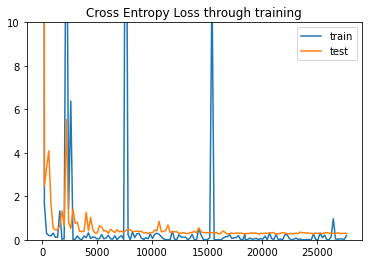

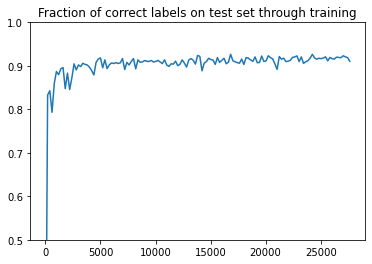

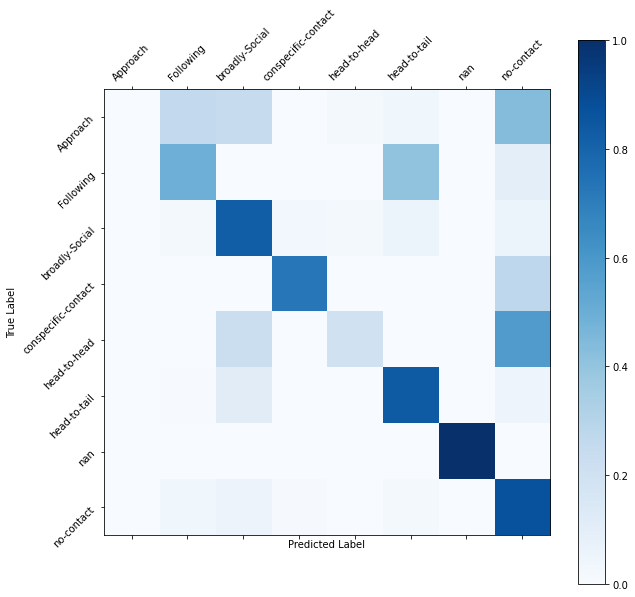

In [176]:
plot_net_results(net, ft_vl, tg_vl)

In [183]:
ft_tr, ft_ts, ft_vl,ft_sp, tg_tr, tg_ts, tg_vl, tg_sp = split_sets(features_all, targets_int, splits=(0.95, 0.02, 0.03),separate_vid_idx=(0,30270))

In [184]:

ft_tr = torch.tensor(ft_tr).float()
ft_ts = torch.tensor(ft_ts).float()
ft_vl = torch.tensor(ft_vl).float()
ft_sp = torch.tensor(ft_sp).float()
tg_tr = torch.tensor(tg_tr).long()
tg_ts = torch.tensor(tg_ts).long()
tg_vl = torch.tensor(tg_vl).long()
tg_sp = torch.tensor(tg_sp).long()

net = MLP(architecture)

net.learn(learning, (ft_tr,tg_tr), (ft_sp, tg_sp))

### EPOCH  0 ###
Time: 0.43, Batch   0, Train Loss (for batch): 74.55, Test Loss: 4.82, Test Correct Frac: 0.615
Time: 1.18, Batch 200, Train Loss (for batch): 0.00, Test Loss: 1.58, Test Correct Frac: 0.748
Time: 1.09, Batch 400, Train Loss (for batch): 0.27, Test Loss: 1.13, Test Correct Frac: 0.781
Time: 0.99, Batch 600, Train Loss (for batch): 0.29, Test Loss: 0.87, Test Correct Frac: 0.776
Time: 1.02, Batch 800, Train Loss (for batch): 0.18, Test Loss: 1.02, Test Correct Frac: 0.833
Time: 1.01, Batch 1000, Train Loss (for batch): 0.65, Test Loss: 1.36, Test Correct Frac: 0.769
Time: 1.17, Batch 1200, Train Loss (for batch): 0.01, Test Loss: 0.87, Test Correct Frac: 0.805
Time: 1.08, Batch 1400, Train Loss (for batch): 0.58, Test Loss: 1.19, Test Correct Frac: 0.802
Time: 1.08, Batch 1600, Train Loss (for batch): 0.23, Test Loss: 1.72, Test Correct Frac: 0.816
Time: 1.09, Batch 1800, Train Loss (for batch): 0.20, Test Loss: 0.90, Test Correct Frac: 0.831
Time: 1.01, Batch 2000, Tra

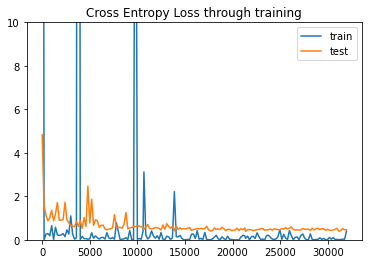

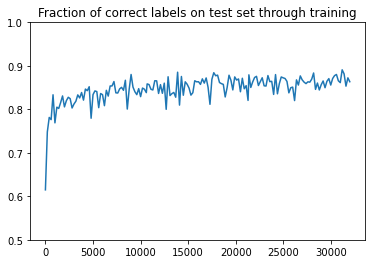

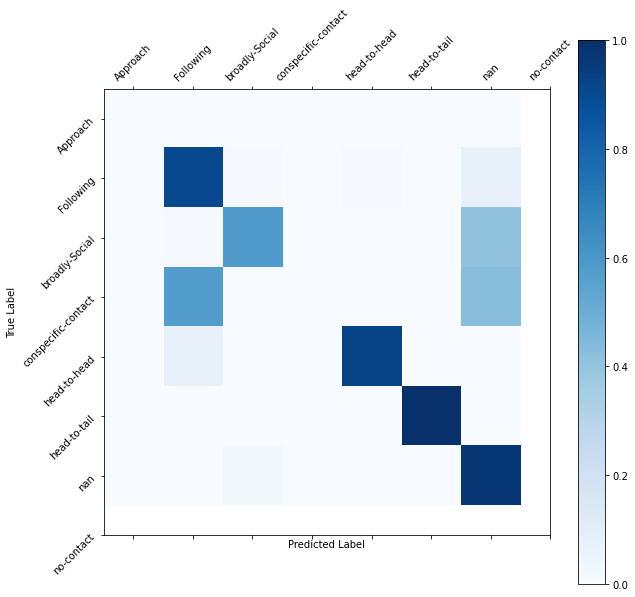

In [185]:
plot_net_results(net, ft_vl, tg_vl)